In [4]:
import pandas as pd
import numpy as np
df = pd.read_csv("./archive (4)/UrbanSound8K.csv")
df.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

In [5]:
import os
import librosa
import librosa.display

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [7]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

In [8]:
# Audio Playback (Optional)
import IPython.display as ipd

# Resampling Library
import resampy  

from tqdm.auto import tqdm

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
dat1, sampling_rate1 = librosa.load('./archive (4)/fold5/100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load('./archive (4)/fold5/100263-2-0-117.wav')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

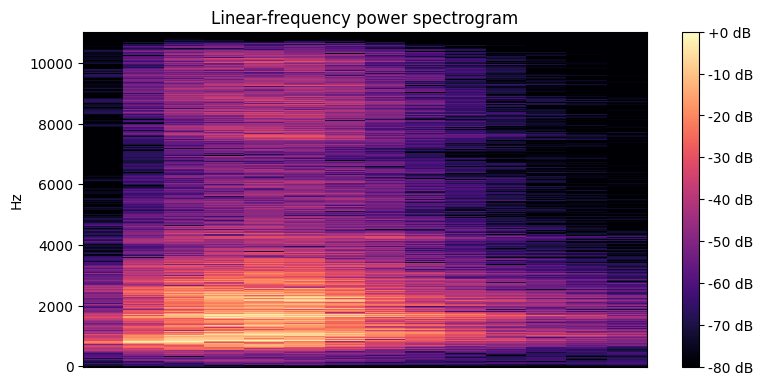

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Register Matplotlib Converters for Time Series Plots
pd.plotting.register_matplotlib_converters()
%matplotlib inline  
plt.figure(figsize=(20, 20))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

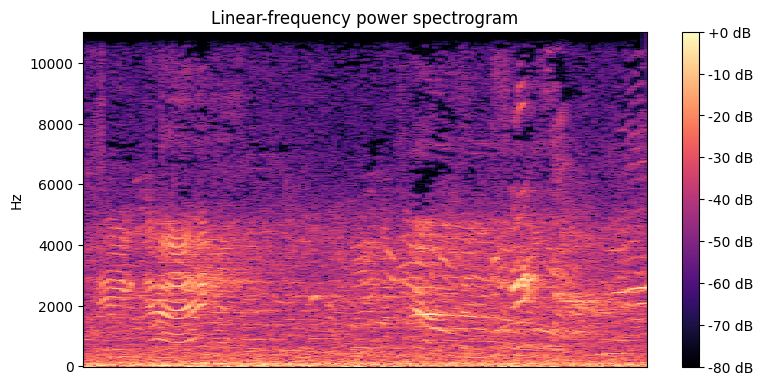

In [8]:
plt.figure(figsize=(20, 20))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

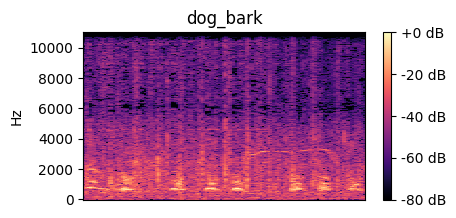

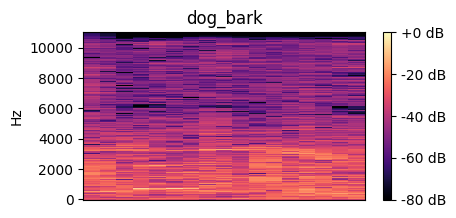

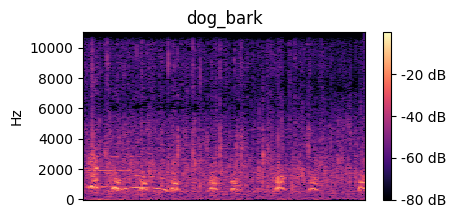

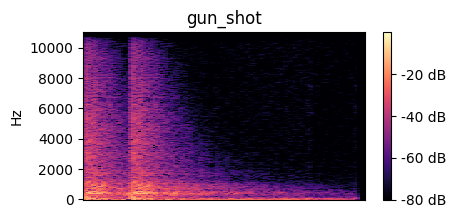

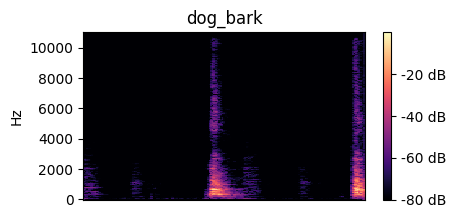

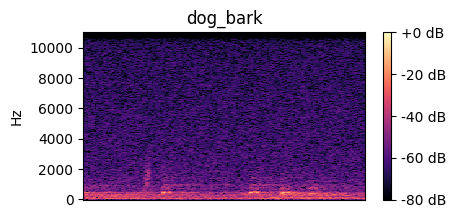

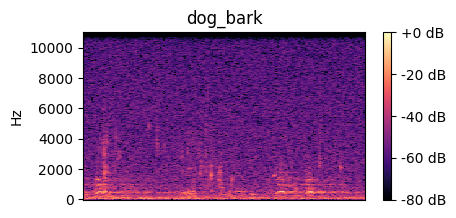

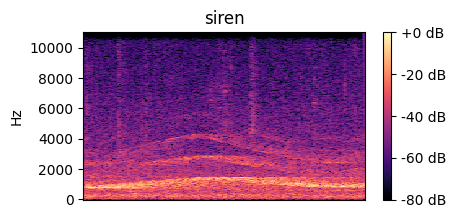

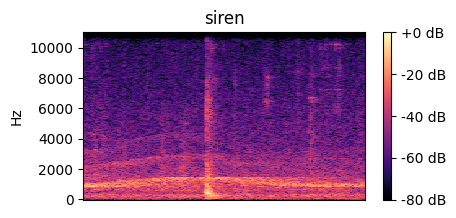

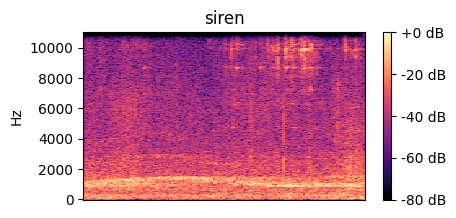

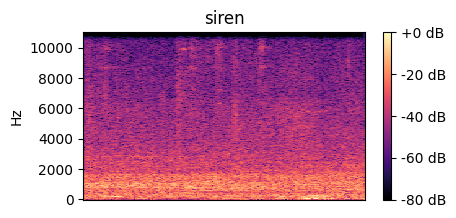

In [9]:
arr = np.array(df["slice_file_name"])
fold = np.array(df["fold"])
cla = np.array(df["class"])

for i in range(100, 121, 2):
    path = './archive (4)/fold' + str(fold[i]) + '/' + arr[i]
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize=(10, 10))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])

In [11]:
import librosa
import numpy as np

def features_extract(file_name, target_duration=4, sr=22050, n_mfcc=50, n_fft=1024):
    target_length = target_duration * sr  # Total samples for 4 seconds

    sample, sample_rate = librosa.load(file_name, sr=sr)
    if len(sample) < target_length:
        sample = np.pad(sample, (0, target_length - len(sample)), mode='constant')

    feature = librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=n_mfcc, n_fft=n_fft)
    max_pad_len = feature.shape[1]  # Maximum possible frames for 4-sec audio
    pad_width = max(0, max_pad_len - feature.shape[1])
    feature_padded = np.pad(feature, pad_width=((0, 0), (0, pad_width)), mode='constant')
    scaled_feature = np.mean(feature_padded.T, axis=0)
    return scaled_feature


extracted = []
path = './archive (4)'

for index_num, row in tqdm(df.iterrows()):
    file_name = os.path.join(os.path.abspath(path), 'fold' + str(row["fold"]), str(row['slice_file_name'])) 
    final_class_labels = row['class']   
    data = features_extract(file_name)    
    extracted.append([data, final_class_labels])


8732it [02:05, 69.71it/s] 


In [12]:
ext_df = pd.DataFrame(extracted,columns=['feature','class'])
ext_df

feature             class
0     [-646.75635, 5.3873677, -9.81038, -4.852548, -...          dog_bark
1     [-490.71515, 98.969734, -42.70029, 51.26325, 9...  children_playing
2     [-525.64197, 111.47854, -37.607727, 43.46369, ...  children_playing
3     [-480.8334, 91.745125, -24.20152, 42.91354, 11...  children_playing
4     [-512.5282, 103.20618, -42.739483, 50.844624, ...  children_playing
...                                                 ...               ...
8727  [-463.6058, 124.70258, -40.755966, 25.904419, ...          car_horn
8728  [-632.8646, 41.30297, -18.6657, 22.987225, -12...          car_horn
8729  [-429.492, 90.46378, -32.355354, 23.182915, -0...          car_horn
8730  [-597.676, 73.3897, -28.41001, 15.767284, -6.7...          car_horn
8731  [-582.2274, 52.76885, -16.783705, 22.564552, 2...          car_horn

[8732 rows x 2 columns]

In [13]:
x = np.array(ext_df['feature'].tolist())
y = np.array(ext_df['class'].tolist())
le = LabelEncoder()

y = to_categorical(le.fit_transform(y))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

print("Number of training samples = ", x_train.shape[0])
print("Number of testing samples = ",x_test.shape[0])

Number of training samples =  6985
Number of testing samples =  1747


CNN

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, LSTM, Dense, Dropout, Flatten, Input

num_labels = y_train.shape[1]  # Number of classes

# Model definition
model = Sequential([
    Input(shape=(50, 1)),  # Corrected input shape for CNN + LSTM

    # CNN Layers (Feature Extraction)
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    Conv1D(256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    # LSTM Layer (Temporal Dependencies)
    LSTM(128, return_sequences=False),  # Reducing sequence length

    # Fully Connected Layers
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Output Layer
    Dense(num_labels, activation='softmax')
])

# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Print Model Summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 48, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 22, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 9, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 4, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 389,642 (1.49 MB)

 Trainable params: 388,746 (1.48 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9880 - loss: 0.0345 - val_accuracy: 0.8998 - val_loss: 0.7663
Epoch 2/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9892 - loss: 0.0360 - val_accuracy: 0.8998 - val_loss: 0.6462
Epoch 3/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9891 - loss: 0.0333 - val_accuracy: 0.9033 - val_loss: 0.6709
Epoch 4/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9909 - loss: 0.0269 - val_accuracy: 0.9147 - val_loss: 0.6220
Epoch 5/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9879 - loss: 0.0315 - val_accuracy: 0.9187 - val_loss: 0.5231
Epoch 6/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9889 - loss: 0.0418 - val_accuracy: 0.9222 - val_loss: 0.5469
Epoch 7/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9915 - loss: 0.0266 - val_accuracy: 0.9101 - val_loss: 0.6795
Epoch 8/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9912 - loss: 0.0414 - val_acc

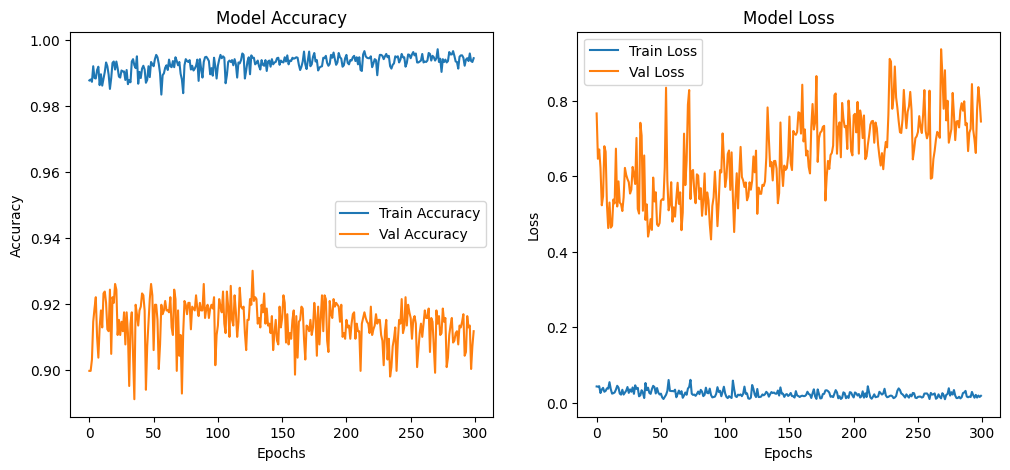

In [25]:

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Train model
history = model.fit(
    x_train, 
    y_train, 
    epochs=300,  
    validation_data=(x_test, y_test),
)

# Function to plot accuracy & loss
import matplotlib.pyplot as plt

def showAccVallLossPlt(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy Plot
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    # Loss Plot
    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Val Loss')
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.show()

# Plot results
showAccVallLossPlt(history)


In [26]:
def extract_feature(file_name, target_duration=4, sr=22050, n_mfcc=50):
    target_length = target_duration * sr 
    audio_data, sample_rate = librosa.load(file_name, sr=sr, res_type='soxr_vhq') 
    if len(audio_data) < target_length:
        audio_data = np.pad(audio_data, (0, target_length - len(audio_data)), mode='constant')
    fea = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=n_mfcc)
    scaled = np.mean(fea.T, axis=0)

    return np.array([scaled])

def print_prediction(file_name):
    pred_fea = extract_feature(file_name) 
    pred_vector = np.argmax(model.predict(pred_fea), axis=-1)
    pred_class = le.inverse_transform(pred_vector)
    print("The predicted class is:", pred_class[0], '\n') 

In [31]:
df

slice_file_name    fsID       start         end  salience  fold  \
0       100032-3-0-0.wav  100032    0.000000    0.317551         1     5   
1     100263-2-0-117.wav  100263   58.500000   62.500000         1     5   
2     100263-2-0-121.wav  100263   60.500000   64.500000         1     5   
3     100263-2-0-126.wav  100263   63.000000   67.000000         1     5   
4     100263-2-0-137.wav  100263   68.500000   72.500000         1     5   
...                  ...     ...         ...         ...       ...   ...   
8727     99812-1-2-0.wav   99812  159.522205  163.522205         2     7   
8728     99812-1-3-0.wav   99812  181.142431  183.284976         2     7   
8729     99812-1-4-0.wav   99812  242.691902  246.197885         2     7   
8730     99812-1-5-0.wav   99812  253.209850  255.741948         2     7   
8731     99812-1-6-0.wav   99812  332.289233  334.821332         2     7   

      classID             class  
0           3          dog_bark  
1           2  children_playing  
2           2  children_playing  
3           2  children_playing  
4           2  children_playing  
...       ...               ...  
8727        1          car_horn  
8728        1          car_horn  
8729        1          car_horn  
8730        1          car_horn  
8731        1          car_horn  

[8732 rows x 8 columns]

In [36]:
print_prediction('./archive (4)/fold10/102857-5-0-12.wav')
ipd.Audio('./archive (4)/fold10/102857-5-0-12.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
The predicted class is: engine_idling 



In [38]:
print_prediction('./archive (4)/fold7/104625-4-0-3.wav')
ipd.Audio('./archive (4)/fold7/104625-4-0-3.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
The predicted class is: drilling 



55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


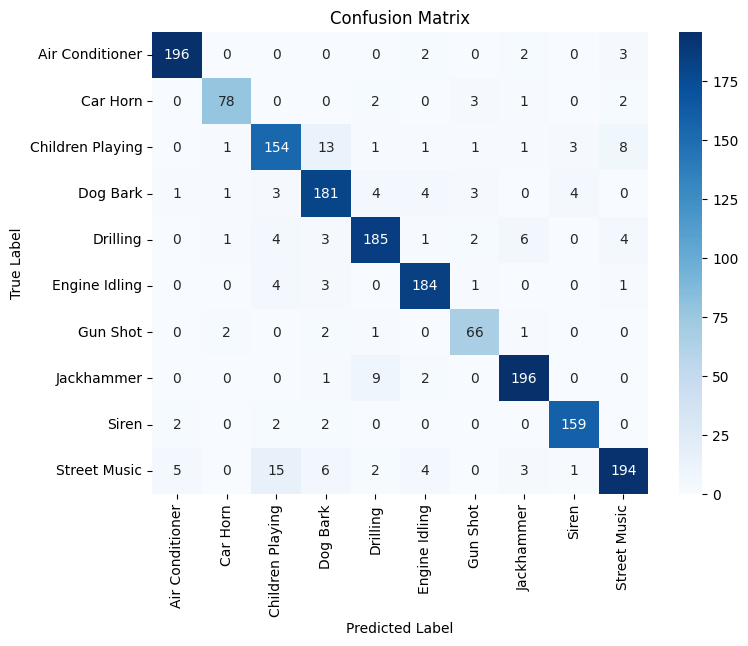

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96       203
           1       0.94      0.91      0.92        86
           2       0.85      0.84      0.84       183
           3       0.86      0.90      0.88       201
           4       0.91      0.90      0.90       206
           5       0.93      0.95      0.94       193
           6       0.87      0.92      0.89        72
           7       0.93      0.94      0.94       208
           8       0.95      0.96      0.96       165
           9       0.92      0.84      0.88       230

    accuracy                           0.91      1747
   macro avg       0.91      0.91      0.91      1747
weighted avg       0.91      0.91      0.91      1747



In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
class_labels = [
    "Air Conditioner",  # 0
    "Car Horn",         # 1
    "Children Playing", # 2
    "Dog Bark",         # 3
    "Drilling",         # 4
    "Engine Idling",    # 5
    "Gun Shot",         # 6
    "Jackhammer",       # 7
    "Siren",            # 8
    "Street Music"      # 9
]

y_pred_probs = model.predict(x_test)  
y_pred = np.argmax(y_pred_probs, axis=1) 

y_true = np.argmax(y_test, axis=1)  # If y_test is one-hot encoded

# Step 3: Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Step 4: Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Step 5: Print Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred))


In [ ]:
# Overall Accuracy
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_true_classes = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# Precision, Recall, and F1-score
report = classification_report(y_true_classes, y_pred_classes, target_names=class_labels)
print("Classification Report:\n", report)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.9118
Classification Report:
                   precision    recall  f1-score   support

 Air Conditioner       0.96      0.97      0.96       203
        Car Horn       0.94      0.91      0.92        86
Children Playing       0.85      0.84      0.84       183
        Dog Bark       0.86      0.90      0.88       201
        Drilling       0.91      0.90      0.90       206
   Engine Idling       0.93      0.95      0.94       193
        Gun Shot       0.87      0.92      0.89        72
      Jackhammer       0.93      0.94      0.94       208
           Siren       0.95      0.96      0.96       165
    Street Music       0.92      0.84      0.88       230

        accuracy                           0.91      1747
       macro avg       0.91      0.91      0.91      1747
    weighted avg       0.91      0.91      0.91      1747



Epoch 1/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.3170 - loss: 1.9144 - val_accuracy: 0.4259 - val_loss: 1.5841
Epoch 2/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.5149 - loss: 1.4142 - val_accuracy: 0.4774 - val_loss: 1.6684
Epoch 3/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.5988 - loss: 1.2268 - val_accuracy: 0.5850 - val_loss: 1.1825
Epoch 4/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6618 - loss: 1.0378 - val_accuracy: 0.6800 - val_loss: 0.9698
Epoch 5/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7150 - loss: 0.8751 - val_accuracy: 0.6010 - val_loss: 1.3326
Epoch 6/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7514 - loss: 0.7741 - val_accuracy: 0.7476 - val_loss: 0.7915
Epoch 7/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7802 - loss: 0.6662 - val_accuracy: 0.8042 - val_loss: 0.5939
Epoch 8/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7984 - loss: 0.6216 -

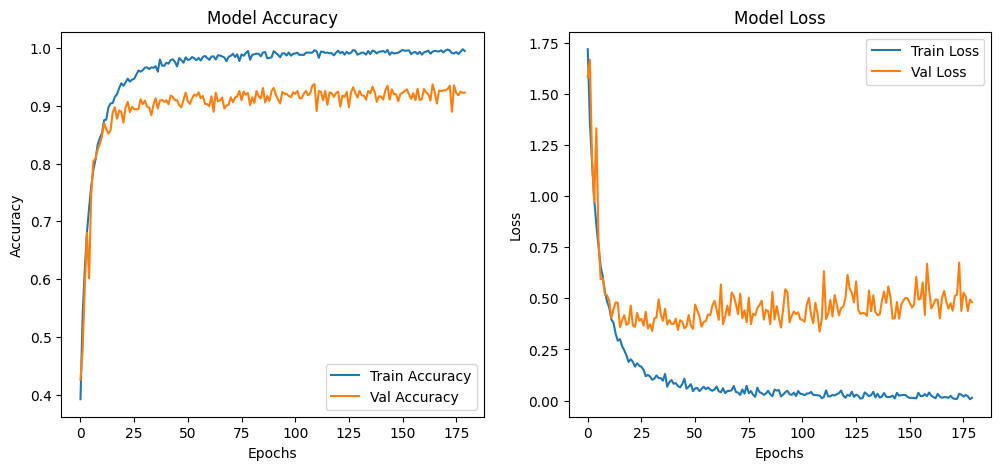

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, Add, GlobalAveragePooling1D, Dense, Dropout, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# ✅ Define Residual Block
def residual_block(x, filters, kernel_size=3, strides=1):
    shortcut = x  # Save input for residual connection

    x = Conv1D(filters, kernel_size, strides=strides, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv1D(filters, kernel_size, strides=1, padding="same")(x)
    x = BatchNormalization()(x)

    # Adjust dimensions of shortcut if needed
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, strides=strides, padding="same")(shortcut)

    x = Add()([x, shortcut])  # Add skip connection
    x = ReLU()(x)
    return x

# ✅ Build ResNet Model
def build_resnet_model(input_shape, num_labels):
    input_layer = Input(shape=input_shape)

    # Initial Conv Layer
    x = Conv1D(64, 3, padding="same")(input_layer)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Residual Blocks
    x = residual_block(x, 64)
    x = residual_block(x, 128)
    x = residual_block(x, 256)

    # Global Average Pooling (better than Flatten)
    x = GlobalAveragePooling1D()(x)

    # Fully Connected Layers
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(10, activation="softmax")(x)

    # Define Model
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

# ✅ Define input shape & labels
input_shape = (50, 1)  # Adjust based on MFCC feature shape
num_labels = y_train.shape[1]  # Assuming one-hot encoded labels

# ✅ Create model
model = build_resnet_model(input_shape, num_labels)

# ✅ Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

# ✅ Train model
history = model.fit(
    x_train, 
    y_train, 
    epochs=180,  
    validation_data=(x_test, y_test),
)

# ✅ Function to Plot Accuracy & Loss
def showAccVallLossPlt(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy Plot
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    # Loss Plot
    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Val Loss')
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.show()

# ✅ Plot Results
showAccVallLossPlt(history)


In [17]:
history = model.fit(
    x_train, 
    y_train, 
    epochs=250,
    initial_epoch = 180,  
    validation_data=(x_test, y_test),
)

Epoch 181/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9908 - loss: 0.0272 - val_accuracy: 0.9130 - val_loss: 0.6021
Epoch 182/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9920 - loss: 0.0265 - val_accuracy: 0.9210 - val_loss: 0.4771
Epoch 183/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9955 - loss: 0.0118 - val_accuracy: 0.9216 - val_loss: 0.5854
Epoch 184/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9969 - loss: 0.0101 - val_accuracy: 0.9244 - val_loss: 0.5250
Epoch 185/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9913 - loss: 0.0290 - val_accuracy: 0.9210 - val_loss: 0.5097
Epoch 186/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9937 - loss: 0.0175 - val_accuracy: 0.9096 - val_loss: 0.5555
Epoch 187/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9893 - loss: 0.0345 - val_accuracy: 0.9199 - val_loss: 0.4997
Epoch 188/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9961 -

In [19]:
history2 = model.fit(
    x_train, 
    y_train, 
    epochs=300,
    initial_epoch = 270,  
    validation_data=(x_test, y_test),
)

Epoch 271/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9936 - loss: 0.0157 - val_accuracy: 0.9262 - val_loss: 0.5111
Epoch 272/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9963 - loss: 0.0093 - val_accuracy: 0.9204 - val_loss: 0.4982
Epoch 273/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9959 - loss: 0.0091 - val_accuracy: 0.9262 - val_loss: 0.5155
Epoch 274/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9970 - loss: 0.0078 - val_accuracy: 0.9290 - val_loss: 0.4873
Epoch 275/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9994 - loss: 0.0030 - val_accuracy: 0.9313 - val_loss: 0.5058
Epoch 276/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9984 - loss: 0.0032 - val_accuracy: 0.9313 - val_loss: 0.5467
Epoch 277/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9970 - loss: 0.0057 - val_accuracy: 0.9353 - val_loss: 0.5422
Epoch 278/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9978 -

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


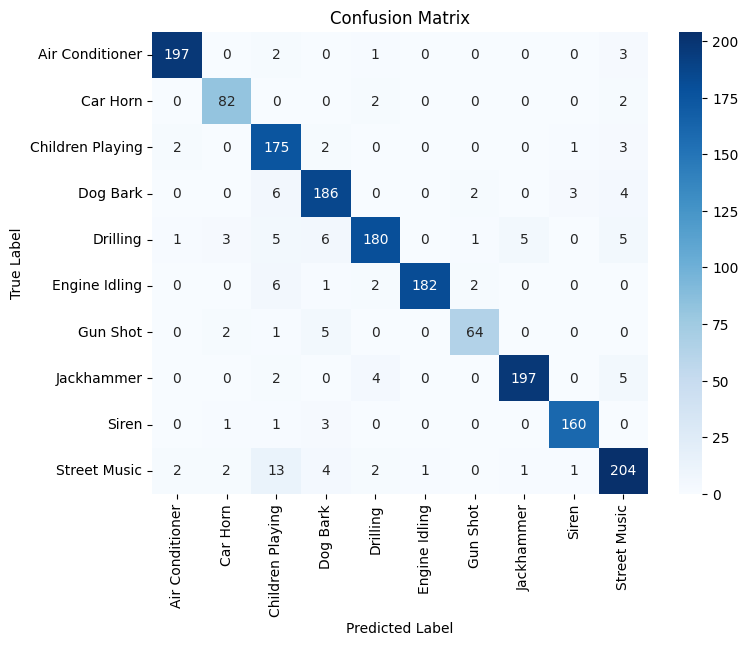

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       203
           1       0.91      0.95      0.93        86
           2       0.83      0.96      0.89       183
           3       0.90      0.93      0.91       201
           4       0.94      0.87      0.91       206
           5       0.99      0.94      0.97       193
           6       0.93      0.89      0.91        72
           7       0.97      0.95      0.96       208
           8       0.97      0.97      0.97       165
           9       0.90      0.89      0.89       230

    accuracy                           0.93      1747
   macro avg       0.93      0.93      0.93      1747
weighted avg       0.93      0.93      0.93      1747



In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
class_labels = [
    "Air Conditioner",  # 0
    "Car Horn",         # 1
    "Children Playing", # 2
    "Dog Bark",         # 3
    "Drilling",         # 4
    "Engine Idling",    # 5
    "Gun Shot",         # 6
    "Jackhammer",       # 7
    "Siren",            # 8
    "Street Music"      # 9
]

y_pred_probs = model.predict(x_test)  
y_pred = np.argmax(y_pred_probs, axis=1) 

y_true = np.argmax(y_test, axis=1)  # If y_test is one-hot encoded

# Step 3: Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Step 4: Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Step 5: Print Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred))
